﷽

In [ ]:
!pip install ipython-autotime
%load_ext autotime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### Downloading Data from Kaggle

In [ ]:
! pip install --upgrade --ignore-installed kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle #created at root folder in colab

In [ ]:
#copy
!cp kaggle.json ~/.kaggle

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

time: 113 ms (started: 2021-02-08 14:30:42 +00:00)


Sir wala Dataset
ASL Fingerspelling Images (RGB & Depth)
Usability
7.5

In [ ]:
# example
!kaggle datasets download -d mrgeislinger/asl-rgb-depth-fingerspelling-spelling-it-out

In [ ]:
#unzip dataset in colab session
!unzip '/content/asl-rgb-depth-fingerspelling-spelling-it-out.zip' -d '/content/drive/MyDrive/z data' # -q for quiet

### Start

In [63]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input
from keras.optimizers import SGD
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import matplotlib.pyplot as plt

import os
import cv2
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm

time: 38.3 ms (started: 2021-02-08 16:40:40 +00:00)


In [128]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("/content/drive/MyDrive/z data"))

# Any results you write to the current directory are saved as output.

['dataset5', 'weights and graphs', '.ipynb_checkpoints']
time: 6.61 ms (started: 2021-02-08 17:58:09 +00:00)


### Data Preprocessing

In [129]:
import glob

def get_labels_images(filepath):
    data_dict = {}
    for directory in glob.glob(filepath):
        images = []
        for file in glob.glob(directory+'/color_*.png'):
            images.append(file)
        data_dict.setdefault(directory[-1], images)
        
    return data_dict

time: 3.31 ms (started: 2021-02-08 17:58:16 +00:00)


In [132]:
dataset_dir = os.path.abspath('/content/drive/MyDrive/z data/dataset5/*/*')
data_dict = get_labels_images(dataset_dir)

time: 1.76 s (started: 2021-02-08 17:59:24 +00:00)


Display some images for sanity

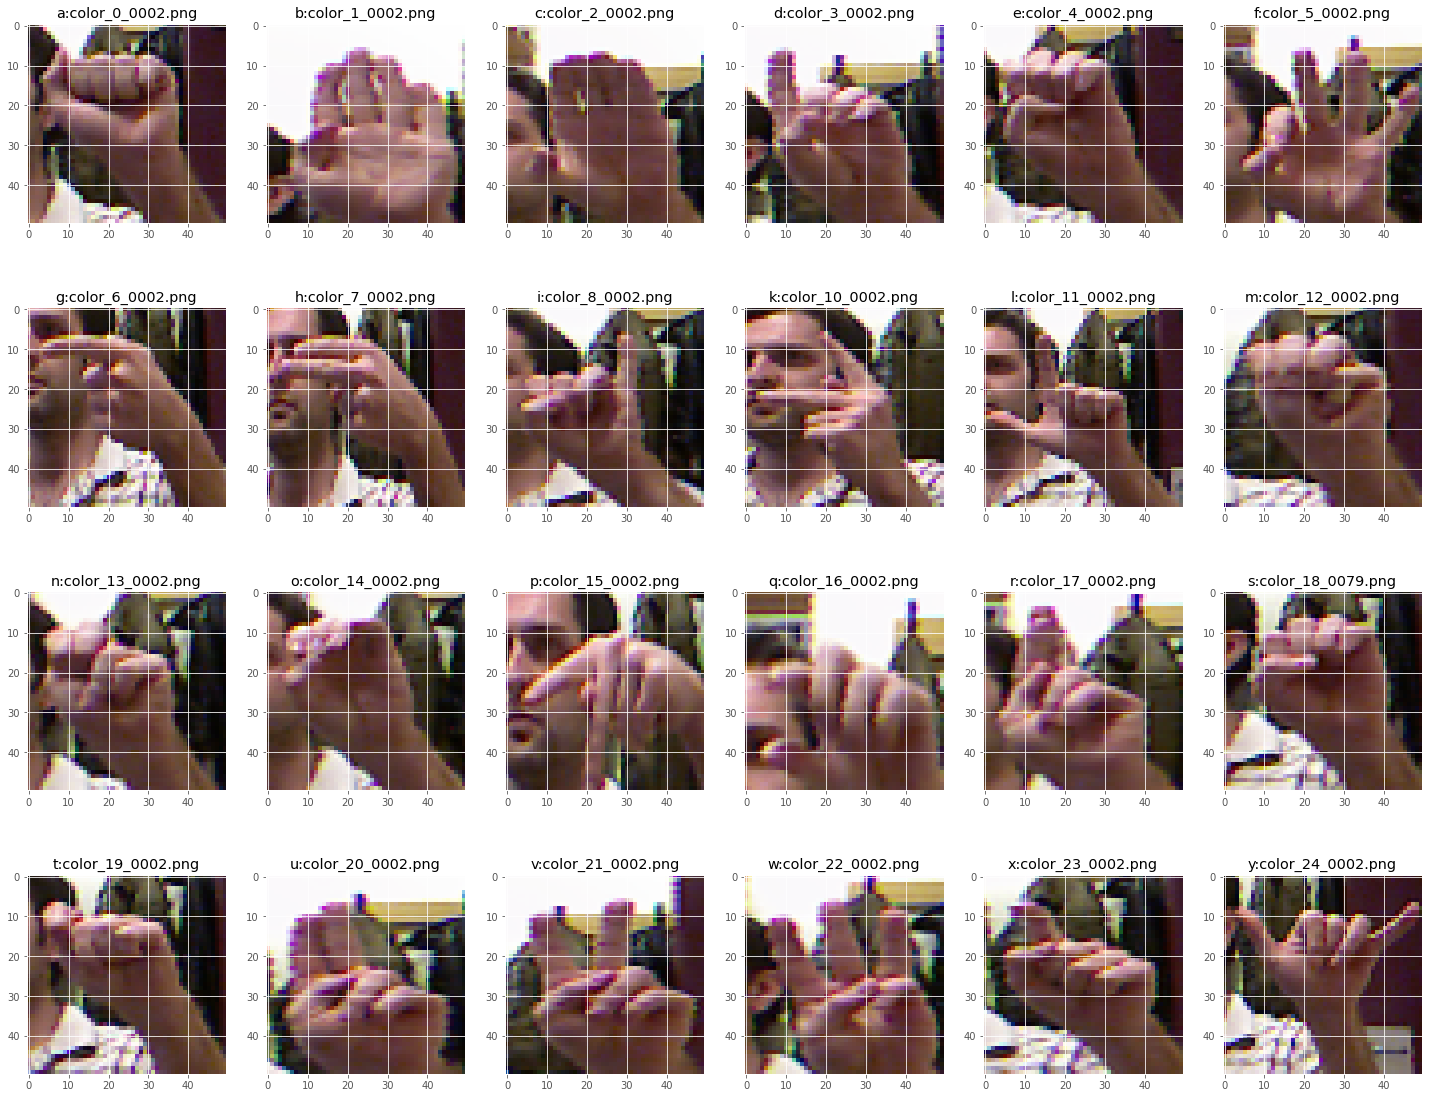

time: 3.34 s (started: 2021-02-08 17:59:28 +00:00)


In [133]:
import cv2
import matplotlib.pyplot as plt

plt.figure(figsize = (25,20))

for i, (k,v) in enumerate(data_dict.items()):
    img = cv2.imread(v[0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (50,50))
    plt.subplot(4,6,i+1)
    plt.imshow(img)
    plt.title(k + ":" + os.path.basename(v[0]))
    
plt.show()

Define function to preprocess images

In [135]:
def preprocess_images(dictionary, height = 75, width = 75):
    images = []
    labels = []
    for k,v in dictionary.items():
        for file in v:
            img = cv2.imread(file)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (height, width))
            img = img / 255.
            images.append(img)
            labels.append(k)
    
    return (np.array(images), np.array(labels).reshape(-1,1))

images, labels = preprocess_images(data_dict)

time: 51.2 s (started: 2021-02-08 18:01:04 +00:00)


Encode our labels

In [136]:
from sklearn.preprocessing import LabelBinarizer

lbl_binarizer = LabelBinarizer()
labels = lbl_binarizer.fit_transform(labels)

time: 20 ms (started: 2021-02-08 18:02:56 +00:00)


Define function to create train, dev, test split

In [137]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size = 0.2, random_state = 1)
X_train, X_dev, Y_train, Y_dev = train_test_split(X_train, Y_train, test_size = 0.25, random_state = 1)

print('Number of training samples:{}, Shape: {}'.format(len(X_train), X_train.shape))
print('Number of dev samples:{}, Shape: {}'.format(len(X_dev), X_dev.shape))
print('Number of test samples:{}, Shape: {}'.format(len(X_test), X_test.shape))

Number of training samples:7527, Shape: (7527, 75, 75, 3)
Number of dev samples:2510, Shape: (2510, 75, 75, 3)
Number of test samples:2510, Shape: (2510, 75, 75, 3)
time: 2.91 s (started: 2021-02-08 18:02:59 +00:00)


Display some images for sanity

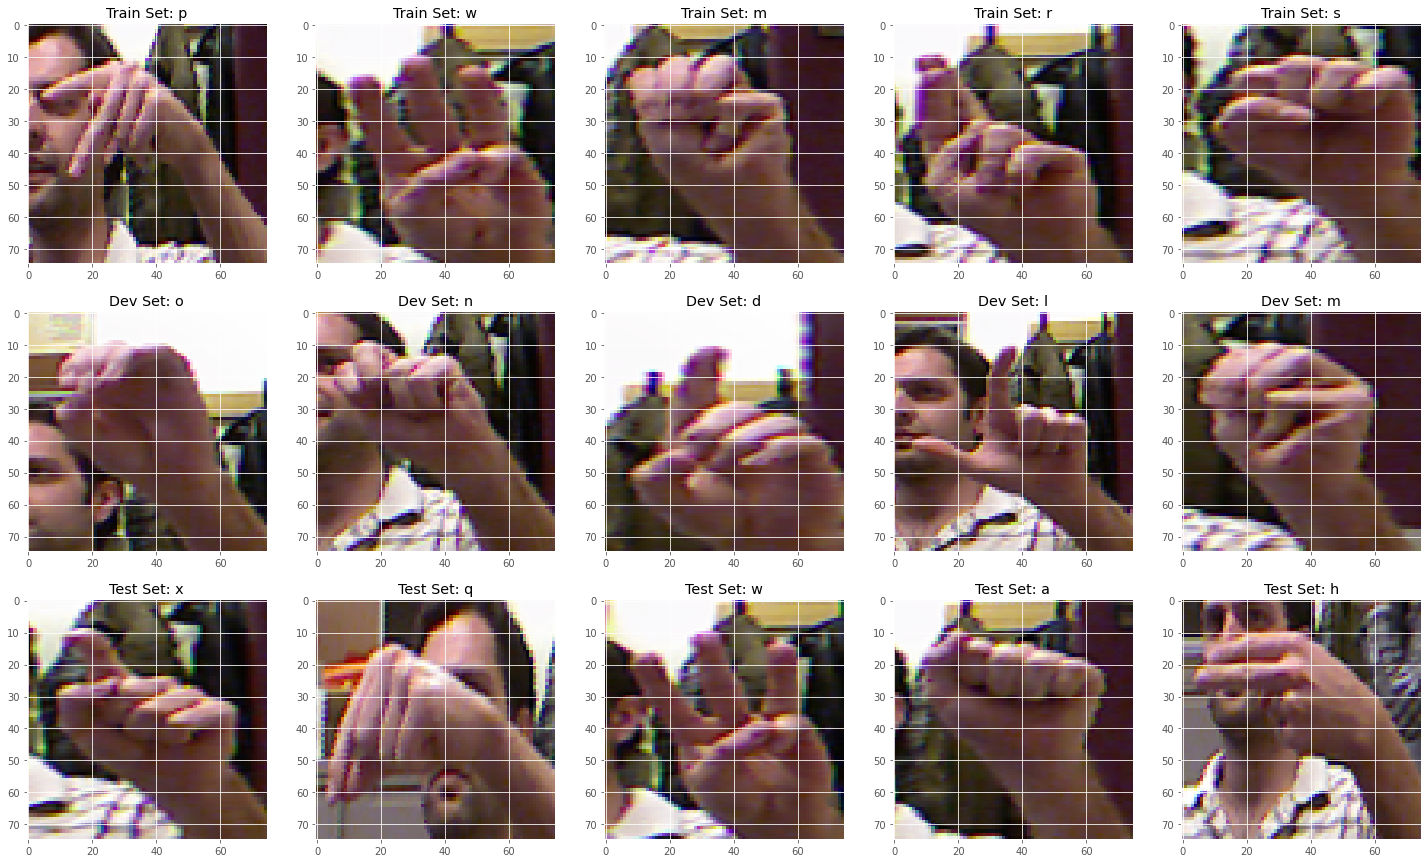

time: 2.24 s (started: 2021-02-08 18:03:11 +00:00)


In [138]:
plt.figure(figsize = (25,15))

for i in range(5):
    plt.subplot(3,5,i+1)
    plt.imshow(X_train[i])
    plt.title('Train Set: {}'.format(lbl_binarizer.classes_[np.argmax(Y_train[i], axis = -1)]))

for i in range(5,10):
    plt.subplot(3,5,i+1)
    plt.imshow(X_dev[i])
    plt.title('Dev Set: {}'.format(lbl_binarizer.classes_[np.argmax(Y_dev[i], axis = -1)]))

for i in range(10,15):
    plt.subplot(3,5,i+1)
    plt.imshow(X_test[i])
    plt.title('Test Set: {}'.format(lbl_binarizer.classes_[np.argmax(Y_test[i], axis = -1)]))

plt.show()

Build our model VGG19

In [141]:
import keras
from keras.applications.vgg19 import VGG19

img_height = 75
img_width = 75
img_channels = 3
num_classes = labels.shape[1]
learning_rate = 1e-5
# weights = '../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'

def build_model():
    base = VGG19(include_top = False, input_shape = (img_height, img_width, img_channels))
    X = base.output
    X = keras.layers.Flatten()(X)
    X = keras.layers.Dense(512, activation = 'relu')(X)
    X = keras.layers.Dropout(0.4)(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Dense(512, activation = 'relu')(X)
    X = keras.layers.Dropout(0.3)(X)
    X = keras.layers.BatchNormalization()(X)
    preds = keras.layers.Dense(num_classes, activation = 'softmax')(X)
    
    model = keras.models.Model(inputs = base.input, outputs = preds)
    model.compile(optimizer = keras.optimizers.RMSprop(lr = learning_rate), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

time: 11.7 ms (started: 2021-02-08 18:04:49 +00:00)


In [142]:
model = build_model()
model.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 75, 75, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0  

Define our callbacks and train our model

In [143]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5, verbose = 0, restore_best_weights = False)]

history = model.fit(X_train, Y_train,
                    epochs = 10,
                    batch_size = 128,
                    validation_data = (X_dev, Y_dev),
                    callbacks = callbacks)

Epoch 1/10
59/59 [==============================] - 45s 647ms/step - loss: 3.1264 - accuracy: 0.1691 - val_loss: 2.2826 - val_accuracy: 0.6649
Epoch 2/10
59/59 [==============================] - 34s 569ms/step - loss: 1.5660 - accuracy: 0.5722 - val_loss: 1.2854 - val_accuracy: 0.8729
Epoch 3/10
59/59 [==============================] - 34s 579ms/step - loss: 0.8727 - accuracy: 0.7955 - val_loss: 0.6216 - val_accuracy: 0.9335
Epoch 4/10
59/59 [==============================] - 34s 569ms/step - loss: 0.5173 - accuracy: 0.8943 - val_loss: 0.3595 - val_accuracy: 0.9653
Epoch 5/10
59/59 [==============================] - 34s 570ms/step - loss: 0.3149 - accuracy: 0.9466 - val_loss: 0.1520 - val_accuracy: 0.9805
Epoch 6/10
59/59 [==============================] - 33s 568ms/step - loss: 0.1983 - accuracy: 0.9731 - val_loss: 0.0725 - val_accuracy: 0.9948
Epoch 7/10
59/59 [==============================] - 33s 569ms/step - loss: 0.1201 - accuracy: 0.9880 - val_loss: 0.0523 - val_accuracy: 0.9956

Plot our metrics

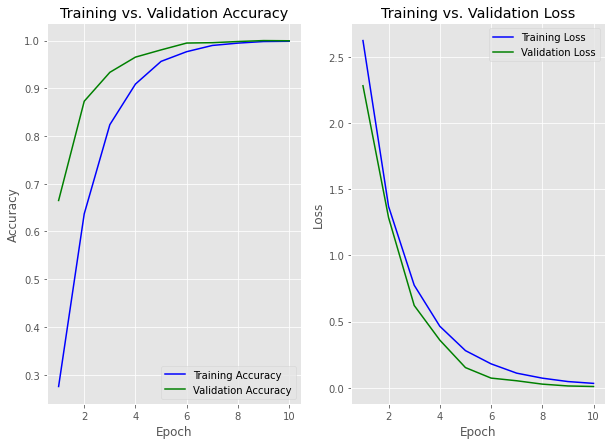

time: 364 ms (started: 2021-02-08 18:10:44 +00:00)


In [144]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize = (10, 7))

plt.subplot(1,2,1)
plt.plot(epochs, acc, c = 'b', label = 'Training Accuracy')
plt.plot(epochs, val_acc, c = 'g', label = 'Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, c = 'b', label = 'Training Loss')
plt.plot(epochs, val_loss, c = 'g', label = 'Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Evaluate model on test set

In [145]:
eval_loss, eval_acc = model.evaluate(X_test, Y_test)
print('Evaluation Loss: {:.4f}'.format(eval_loss * 100))
print('Evaluation Accuracy: {:.2f}'.format(eval_acc * 100))


79/79 [==============================] - 5s 61ms/step - loss: 0.0087 - accuracy: 0.9992
Evaluation Loss: 0.8671
Evaluation Accuracy: 99.92
time: 5.54 s (started: 2021-02-08 18:10:44 +00:00)


Make predictions

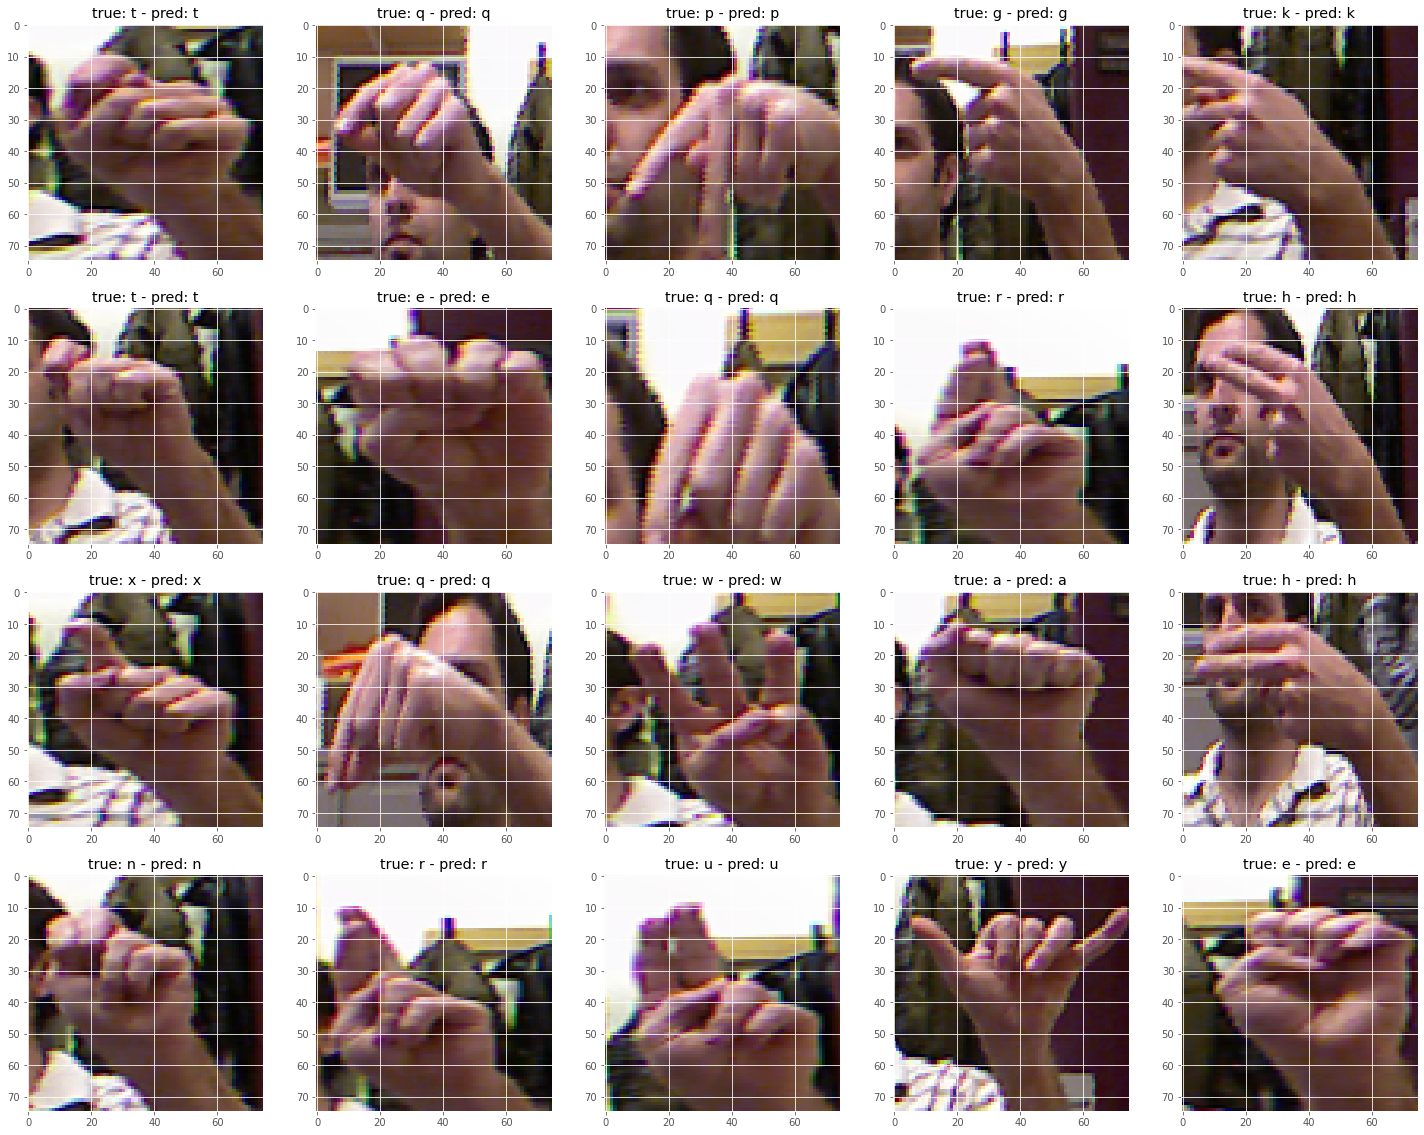

time: 7.37 s (started: 2021-02-08 18:10:50 +00:00)


In [146]:
preds = model.predict(X_test)

plt.figure(figsize = (25,20))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(X_test[i])
    plt.title('true: {} - pred: {}'.format(lbl_binarizer.classes_[np.argmax(Y_test[i], axis = -1)], lbl_binarizer.classes_[np.argmax(preds[i], axis = -1)]))
    
plt.show()

In [147]:
score = model.evaluate(X_test, Y_test, batch_size=64)
print('Test Loss = ', score[0]*100)
print('Test Accuracy = ', score[1]*100)

40/40 [==============================] - 5s 90ms/step - loss: 0.0087 - accuracy: 0.9992
Test Loss =  0.8670986630022526
Test Accuracy =  99.92032051086426
time: 4.68 s (started: 2021-02-08 18:10:57 +00:00)


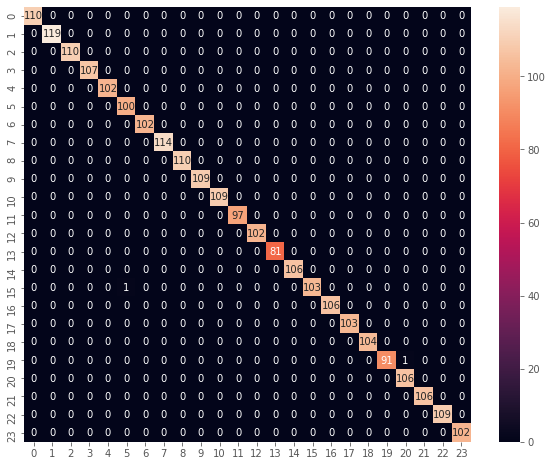

time: 6.68 s (started: 2021-02-08 18:11:02 +00:00)


In [148]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
# Making prediction
y_pred = model.predict(X_test)
y_true = np.argmax(Y_test, axis=-1)

# Plotting the confusion matrix

sns.heatmap(confusion_matrix(y_true, np.argmax(y_pred, axis=1)),annot=True,fmt="d")

Test with custom images

In [150]:
custom_images_path = '/content/drive/MyDrive/z data/custom-images'

def prepare_custom_images(filepath, height = 75, width = 75):
    images = []
    for file in os.listdir(filepath):
        img = cv2.imread(os.path.join(filepath,file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (height, width))
        img = img / 255.
        images.append(img)
    
    return np.array(images)

custom_images = prepare_custom_images(custom_images_path)

time: 90 ms (started: 2021-02-08 18:14:32 +00:00)


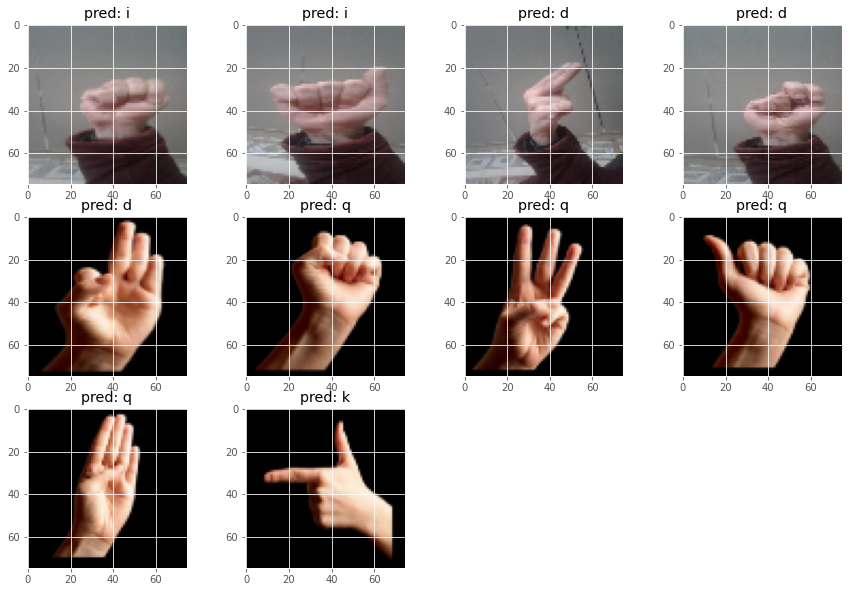

time: 1.78 s (started: 2021-02-08 18:14:58 +00:00)


In [151]:
custom_preds = model.predict(custom_images)

plt.figure(figsize = (15,10))
for i in range(len(custom_preds)):
    plt.subplot(3,4,i+1)
    plt.imshow(custom_images[i])
    plt.title('pred: {}'.format(lbl_binarizer.classes_[np.argmax(custom_preds[i], axis = -1)]))
    
plt.show()

Save model

In [152]:
file_name = '1'
model_path = '/content/drive/MyDrive/z data/weights and graphs/'+file_name+'_model.h5'
# model_path
model.save(model_path)

time: 1.23 s (started: 2021-02-08 18:16:19 +00:00)


vgg AUGMENTED

In [153]:
#vgg AUGMENTED
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import Model
# load VGG16 model without classification layers
model = VGG19(include_top=False, input_shape=(75, 75, 3) )
# add new classification layers
flat1 = Flatten()(model.layers[-1].output) # flatten last layer
class1 = Dense(1024, activation='relu')(flat1) # add FC layer on previous layer
output = Dense(num_classes, activation='softmax')(class1) # add softmax layer
model = Model(inputs=model.inputs, outputs=output)

model.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 75, 75, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0  

In [154]:
from keras.optimizers import SGD
sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

datagen = ImageDataGenerator(
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(X_train)

HdAug = model.fit(datagen.flow(X_train, Y_train, batch_size=128),
              epochs=10, 
              # validation_data=(X_valid, y_valid)
               validation_data = (X_dev, Y_dev))


# save the model's trained weights
model.save_weights('/content/drive/MyDrive/z data/weights and graphs/'+'aug1'+'_model.h5')

Epoch 1/10
59/59 [==============================] - 35s 581ms/step - loss: 2.9992 - accuracy: 0.1332 - val_loss: 1.4787 - val_accuracy: 0.5088
Epoch 2/10
59/59 [==============================] - 34s 579ms/step - loss: 1.1704 - accuracy: 0.6213 - val_loss: 0.5260 - val_accuracy: 0.8171
Epoch 3/10
59/59 [==============================] - 34s 581ms/step - loss: 0.4749 - accuracy: 0.8445 - val_loss: 0.5006 - val_accuracy: 0.8231
Epoch 4/10
59/59 [==============================] - 34s 582ms/step - loss: 0.3210 - accuracy: 0.8971 - val_loss: 0.2875 - val_accuracy: 0.9072
Epoch 5/10
59/59 [==============================] - 34s 581ms/step - loss: 0.1841 - accuracy: 0.9397 - val_loss: 0.1643 - val_accuracy: 0.9390
Epoch 6/10
59/59 [==============================] - 34s 580ms/step - loss: 0.1776 - accuracy: 0.9451 - val_loss: 0.1169 - val_accuracy: 0.9645
Epoch 7/10
59/59 [==============================] - 34s 581ms/step - loss: 0.1204 - accuracy: 0.9593 - val_loss: 0.1446 - val_accuracy: 0.9474

In [155]:
score = model.evaluate(X_test, Y_test, batch_size=64)
print('Test Loss = ', score[0])
print('Test Accuracy = ', score[1])

40/40 [==============================] - 4s 90ms/step - loss: 0.0796 - accuracy: 0.9725
Test Loss =  0.07955168187618256
Test Accuracy =  0.9725099802017212
time: 3.75 s (started: 2021-02-08 18:22:11 +00:00)


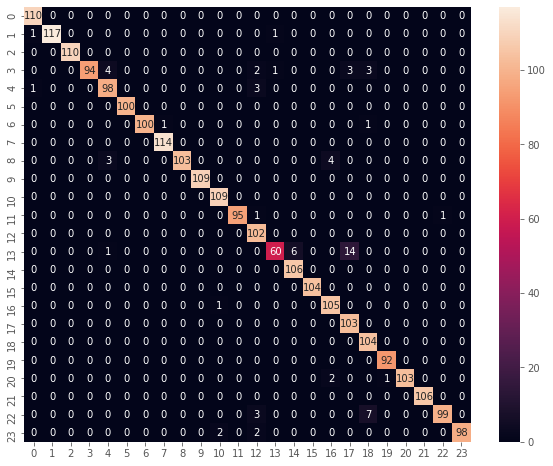

time: 6.94 s (started: 2021-02-08 18:22:15 +00:00)


In [156]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Making prediction
y_pred = model.predict(X_test)
y_true = np.argmax(Y_test, axis=-1)

import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
sns.heatmap(confusion_matrix(y_true, np.argmax(y_pred, axis=1)),annot=True,fmt="d")



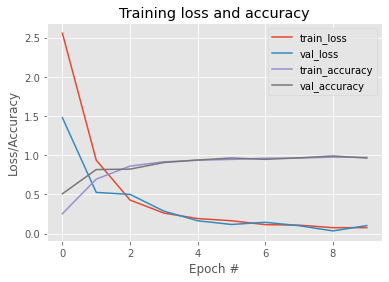

time: 194 ms (started: 2021-02-08 18:22:22 +00:00)


In [157]:


# Lurning Curve

import matplotlib.pyplot as plt
N = np.arange(0, 10)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, HdAug.history['loss'], label='train_loss')
plt.plot(N, HdAug.history['val_loss'], label='val_loss')
plt.plot(N, HdAug.history['accuracy'], label='train_accuracy')
plt.plot(N, HdAug.history['val_accuracy'], label='val_accuracy')
plt.title('Training loss and accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()



ResNet50

In [158]:
# load Resnet50 model without classification layers
from keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input
# load model
model = ResNet50(include_top=False, input_shape=(75,75,3))

# add new classification layers
flat1 = Flatten()(model.layers[-1].output) # flatten last layer
class1 = Dense(1024, activation='relu')(flat1) # add FC layer on previous layer
output = Dense(num_classes, activation='softmax')(class1) # add softmax layer
model = Model(inputs=model.inputs, outputs=output)

model.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 81, 81, 3)    0           input_22[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 38, 38, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 38, 38, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [159]:
from keras.optimizers import SGD
sgd = SGD(lr=0.0001, decay=1e-7, momentum=.9)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

H = model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_dev, Y_dev))

# save the model's trained weights
model.save_weights('/content/drive/MyDrive/z data/weights and graphs/'+'ResNet50'+'_model.h5')

Epoch 1/10
59/59 [==============================] - 42s 566ms/step - loss: 3.2905 - accuracy: 0.2240 - val_loss: 8.9881 - val_accuracy: 0.0426
Epoch 2/10
59/59 [==============================] - 29s 498ms/step - loss: 0.5423 - accuracy: 0.8746 - val_loss: 26.8603 - val_accuracy: 0.0426
Epoch 3/10
59/59 [==============================] - 29s 498ms/step - loss: 0.2224 - accuracy: 0.9628 - val_loss: 66.7332 - val_accuracy: 0.0426
Epoch 4/10
59/59 [==============================] - 29s 498ms/step - loss: 0.1334 - accuracy: 0.9860 - val_loss: 99.0911 - val_accuracy: 0.0426
Epoch 5/10
59/59 [==============================] - 29s 498ms/step - loss: 0.0768 - accuracy: 0.9971 - val_loss: 122.2850 - val_accuracy: 0.0426
Epoch 6/10
59/59 [==============================] - 29s 498ms/step - loss: 0.0580 - accuracy: 0.9982 - val_loss: 135.9909 - val_accuracy: 0.0426
Epoch 7/10
59/59 [==============================] - 29s 499ms/step - loss: 0.0440 - accuracy: 0.9991 - val_loss: 134.5663 - val_accurac

In [160]:
score = model.evaluate(X_test, Y_test, batch_size=64)
print('Test Loss = ', score[0])
print('Test Accuracy = ', score[1])

40/40 [==============================] - 4s 87ms/step - loss: 76.4720 - accuracy: 0.0494
Test Loss =  76.47203063964844
Test Accuracy =  0.0494023896753788
time: 4.11 s (started: 2021-02-08 18:27:33 +00:00)


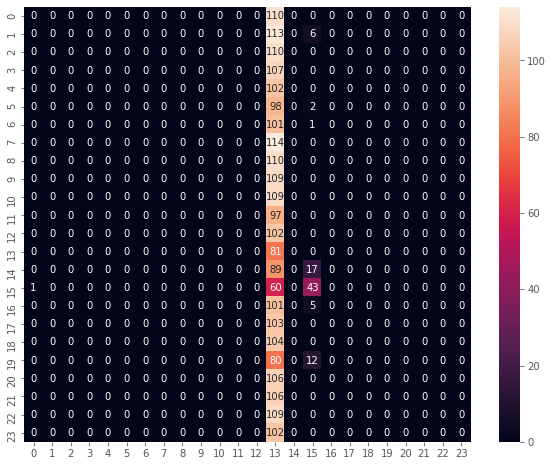

time: 7.48 s (started: 2021-02-08 18:27:37 +00:00)


In [161]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
# Making prediction
y_pred = model.predict(X_test)
y_true = np.argmax(Y_test, axis=-1)

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_true, np.argmax(y_pred, axis=1)),annot=True,fmt="d")

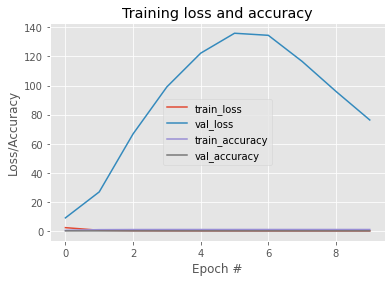

time: 236 ms (started: 2021-02-08 18:27:45 +00:00)


In [162]:


# Learning Curve

import matplotlib.pyplot as plt
N = np.arange(0, 10)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, H.history['loss'], label='train_loss')
plt.plot(N, H.history['val_loss'], label='val_loss')
plt.plot(N, H.history['accuracy'], label='train_accuracy')
plt.plot(N, H.history['val_accuracy'], label='val_accuracy')
plt.title('Training loss and accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()



In [163]:
#resnet AUGMENTED
from keras.preprocessing.image import ImageDataGenerator

# load ResNet50 model without classification layers
model = ResNet50(include_top=False, input_shape=(75, 75, 3) )
# add new classification layers
flat1 = Flatten()(model.layers[-1].output) # flatten last layer
class1 = Dense(1024, activation='relu')(flat1) # add FC layer on previous layer
output = Dense(num_classes, activation='softmax')(class1) # add softmax layer
model = Model(inputs=model.inputs, outputs=output)

model.summary()

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 81, 81, 3)    0           input_23[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 38, 38, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 38, 38, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [164]:
from keras.optimizers import SGD
sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

datagen = ImageDataGenerator(
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(X_train)

HdAug = model.fit(datagen.flow(X_train, Y_train, batch_size=128),
              epochs=10, 
              validation_data=(X_dev, Y_dev))


# save the model's trained weights
model.save_weights('/content/drive/MyDrive/z data/weights and graphs/'+'ResNet50_aug'+'_model.h5')

Epoch 1/10
59/59 [==============================] - 38s 552ms/step - loss: 3.0411 - accuracy: 0.2508 - val_loss: 8.8135 - val_accuracy: 0.0426
Epoch 2/10
59/59 [==============================] - 32s 533ms/step - loss: 0.5893 - accuracy: 0.8114 - val_loss: 14.3021 - val_accuracy: 0.0386
Epoch 3/10
59/59 [==============================] - 32s 533ms/step - loss: 0.2899 - accuracy: 0.9053 - val_loss: 26.0421 - val_accuracy: 0.0446
Epoch 4/10
59/59 [==============================] - 32s 534ms/step - loss: 0.1728 - accuracy: 0.9445 - val_loss: 20.2633 - val_accuracy: 0.0446
Epoch 5/10
59/59 [==============================] - 31s 532ms/step - loss: 0.1181 - accuracy: 0.9614 - val_loss: 20.9050 - val_accuracy: 0.0446
Epoch 6/10
59/59 [==============================] - 31s 531ms/step - loss: 0.0896 - accuracy: 0.9685 - val_loss: 13.2103 - val_accuracy: 0.0518
Epoch 7/10
59/59 [==============================] - 31s 531ms/step - loss: 0.0715 - accuracy: 0.9784 - val_loss: 7.2859 - val_accuracy: 0

In [165]:
score = model.evaluate(X_test, Y_test, batch_size=64)
print('Test Loss = ', score[0])
print('Test Accuracy = ', score[1])

40/40 [==============================] - 3s 77ms/step - loss: 5.1229 - accuracy: 0.0502
Test Loss =  5.1228532791137695
Test Accuracy =  0.050199203193187714
time: 3.77 s (started: 2021-02-08 18:33:11 +00:00)


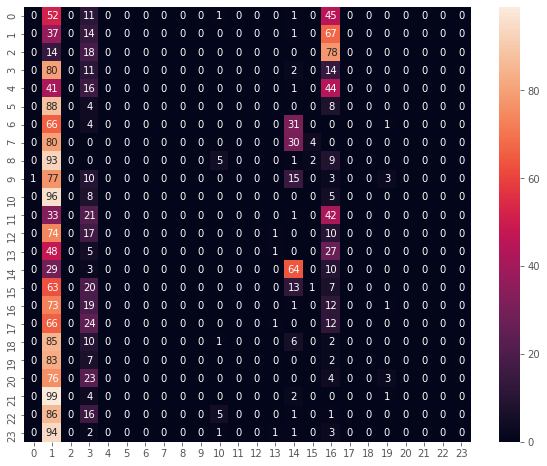

time: 7.93 s (started: 2021-02-08 18:33:15 +00:00)


In [166]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
# Making prediction
y_pred = model.predict(X_test)
y_true = np.argmax(Y_test, axis=-1)

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_true, np.argmax(y_pred, axis=1)),annot=True,fmt="d")

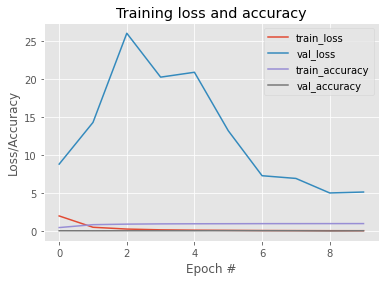

time: 200 ms (started: 2021-02-08 18:33:23 +00:00)


In [167]:
# Learning Curve

import matplotlib.pyplot as plt
N = np.arange(0, 10)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, HdAug.history['loss'], label='train_loss')
plt.plot(N, HdAug.history['val_loss'], label='val_loss')
plt.plot(N, HdAug.history['accuracy'], label='train_accuracy')
plt.plot(N, HdAug.history['val_accuracy'], label='val_accuracy')
plt.title('Training loss and accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()


InceptionV3

In [168]:
# load InceptionV3 model without classification layers
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input

# load model
model = InceptionV3(include_top=False,  input_shape=(75,75,3))

# add new classification layers
flat1 = Flatten()(model.layers[-1].output) # flatten last layer
class1 = Dense(1024, activation='relu')(flat1) # add FC layer on previous layer
output = Dense(num_classes, activation='softmax')(class1) # add softmax layer
model = Model(inputs=model.inputs, outputs=output)

model.summary()

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 37, 37, 32)   864         input_24[0][0]                   
__________________________________________________________________________________________________
batch_normalization_196 (BatchN (None, 37, 37, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 37, 37, 32)   0           batch_normalization_196[0][0]    
___________________________________________________________________________________________

In [169]:
from keras.optimizers import SGD

sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

H = model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_dev, Y_dev))

# save the model's trained weights
model.save_weights('/content/drive/MyDrive/z data/weights and graphs/'+'Inceptionv3'+'_model.h5')

Epoch 1/10
59/59 [==============================] - 33s 390ms/step - loss: 3.1426 - accuracy: 0.0830 - val_loss: 3.1897 - val_accuracy: 0.0633
Epoch 2/10
59/59 [==============================] - 17s 289ms/step - loss: 2.2457 - accuracy: 0.5966 - val_loss: 2.3360 - val_accuracy: 0.4402
Epoch 3/10
59/59 [==============================] - 17s 289ms/step - loss: 0.9038 - accuracy: 0.8707 - val_loss: 0.9903 - val_accuracy: 0.8896
Epoch 4/10
59/59 [==============================] - 17s 288ms/step - loss: 0.2536 - accuracy: 0.9653 - val_loss: 0.3791 - val_accuracy: 0.9546
Epoch 5/10
59/59 [==============================] - 17s 290ms/step - loss: 0.0859 - accuracy: 0.9939 - val_loss: 0.1682 - val_accuracy: 0.9777
Epoch 6/10
59/59 [==============================] - 17s 288ms/step - loss: 0.0447 - accuracy: 0.9967 - val_loss: 0.0820 - val_accuracy: 0.9904
Epoch 7/10
59/59 [==============================] - 17s 289ms/step - loss: 0.0252 - accuracy: 0.9994 - val_loss: 0.0416 - val_accuracy: 0.9960

In [170]:
score = model.evaluate(X_test, Y_test, batch_size=64)
print('Test Loss = ', score[0])
print('Test Accuracy = ', score[1])

40/40 [==============================] - 4s 69ms/step - loss: 0.0177 - accuracy: 0.9968
Test Loss =  0.01765403151512146
Test Accuracy =  0.9968127608299255
time: 3.79 s (started: 2021-02-08 18:36:35 +00:00)


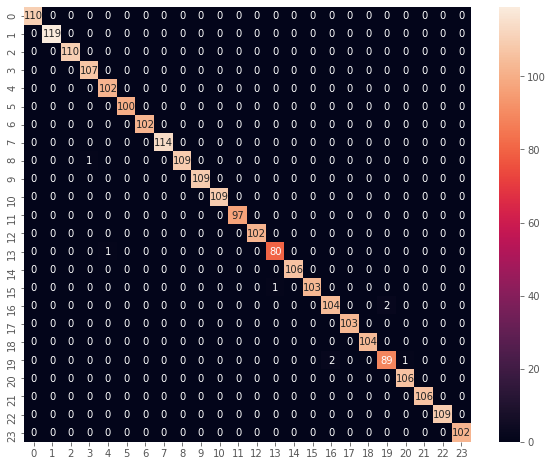

time: 7.32 s (started: 2021-02-08 18:36:39 +00:00)


In [171]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
# Making prediction
y_pred = model.predict(X_test)
y_true = np.argmax(Y_test, axis=-1)

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_true, np.argmax(y_pred, axis=1)),annot=True,fmt="d")

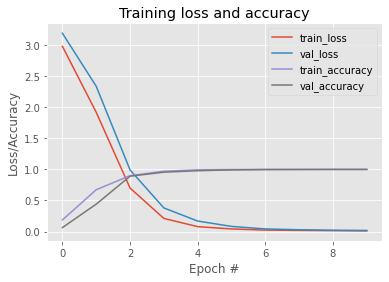

time: 201 ms (started: 2021-02-08 18:36:47 +00:00)


In [172]:
# Learning Curve

N = np.arange(0, 10)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, H.history['loss'], label='train_loss')
plt.plot(N, H.history['val_loss'], label='val_loss')
plt.plot(N, H.history['accuracy'], label='train_accuracy')
plt.plot(N, H.history['val_accuracy'], label='val_accuracy')
plt.title('Training loss and accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [173]:
#InceptionV3 AUGMENTED
from keras.preprocessing.image import ImageDataGenerator

# load VGG16 model without classification layers
model = InceptionV3(include_top=False, input_shape=(75, 75, 3) )
# add new classification layers
flat1 = Flatten()(model.layers[-1].output) # flatten last layer
class1 = Dense(1024, activation='relu')(flat1) # add FC layer on previous layer
output = Dense(num_classes, activation='softmax')(class1) # add softmax layer
model = Model(inputs=model.inputs, outputs=output)

model.summary()

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 37, 37, 32)   864         input_25[0][0]                   
__________________________________________________________________________________________________
batch_normalization_290 (BatchN (None, 37, 37, 32)   96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 37, 37, 32)   0           batch_normalization_290[0][0]    
___________________________________________________________________________________________

In [174]:
from keras.optimizers import SGD
sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

datagen = ImageDataGenerator(
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(X_train)

HdAug = model.fit(datagen.flow(X_train, Y_train, batch_size=128),
              epochs=5, 
              validation_data=(X_dev, Y_dev))


# save the model's trained weights
model.save_weights('/content/drive/MyDrive/z data/weights and graphs/'+'Inceptionv3'+'_model.h5')

Epoch 1/10
59/59 [==============================] - 29s 366ms/step - loss: 3.1826 - accuracy: 0.0586 - val_loss: 3.1335 - val_accuracy: 0.0876
Epoch 2/10
59/59 [==============================] - 20s 339ms/step - loss: 3.0024 - accuracy: 0.2015 - val_loss: 3.0096 - val_accuracy: 0.1351
Epoch 3/10
59/59 [==============================] - 20s 342ms/step - loss: 2.4508 - accuracy: 0.4043 - val_loss: 2.2160 - val_accuracy: 0.4251
Epoch 4/10
59/59 [==============================] - 20s 343ms/step - loss: 1.6359 - accuracy: 0.5985 - val_loss: 1.3349 - val_accuracy: 0.6586
Epoch 5/10
59/59 [==============================] - 20s 341ms/step - loss: 0.9419 - accuracy: 0.7495 - val_loss: 0.7705 - val_accuracy: 0.7976
Epoch 6/10
59/59 [==============================] - 20s 340ms/step - loss: 0.5992 - accuracy: 0.8350 - val_loss: 0.4948 - val_accuracy: 0.8697
Epoch 7/10
59/59 [==============================] - 20s 339ms/step - loss: 0.4401 - accuracy: 0.8704 - val_loss: 0.3507 - val_accuracy: 0.9028

In [175]:
score = model.evaluate(X_test, Y_test, batch_size=64)
print('Test Loss = ', score[0])
print('Test Accuracy = ', score[1])

40/40 [==============================] - 2s 51ms/step - loss: 0.1321 - accuracy: 0.9614
Test Loss =  0.13211841881275177
Test Accuracy =  0.9613545536994934
time: 2.18 s (started: 2021-02-08 18:40:23 +00:00)


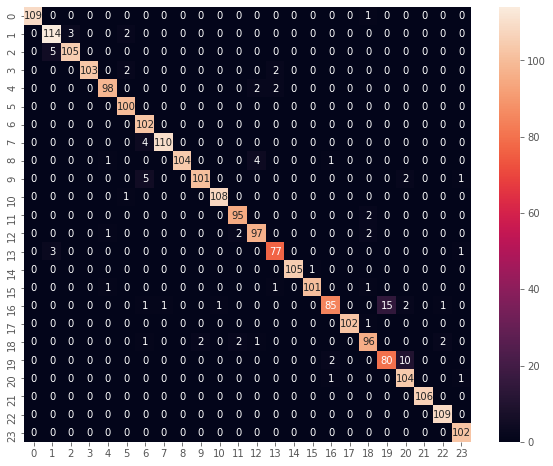

time: 5.57 s (started: 2021-02-08 18:42:31 +00:00)


In [177]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
# Making prediction
y_pred = model.predict(X_test)
y_true = np.argmax(Y_test, axis=-1)

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_true, np.argmax(y_pred, axis=1)),annot=True,fmt="d")

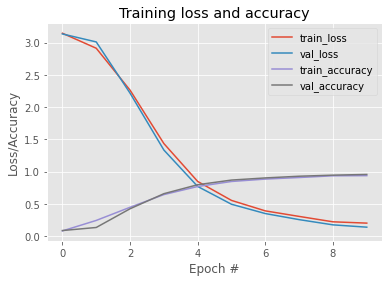

time: 223 ms (started: 2021-02-08 18:42:55 +00:00)


In [178]:
# LearningCurve
import matplotlib.pyplot as plt
N = np.arange(0, 10)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, HdAug.history['loss'], label='train_loss')
plt.plot(N, HdAug.history['val_loss'], label='val_loss')
plt.plot(N, HdAug.history['accuracy'], label='train_accuracy')
plt.plot(N, HdAug.history['val_accuracy'], label='val_accuracy')
plt.title('Training loss and accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()